<a href="https://colab.research.google.com/github/ethanbrown33/lane_line_detection/blob/main/lane_line_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/adc_data')

import sys
import cv2
from matplotlib import pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


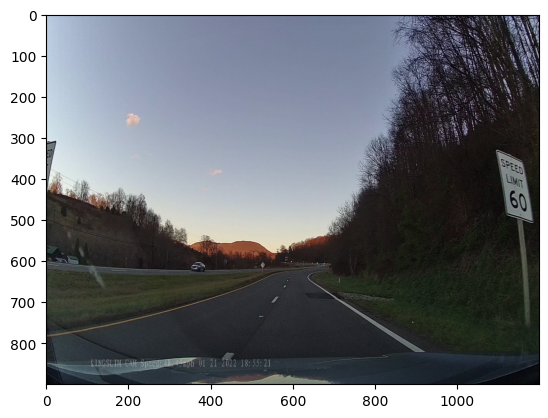

In [173]:
# Load image
path = ["challenge_video_frame_1.jpg",
         "harder_challenge_video_frame_10.jpg",
         "frame0.jpg",
         "step0.png"]

image = cv2.imread(path[2])
image = cv2.resize(image, (1200, 900))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

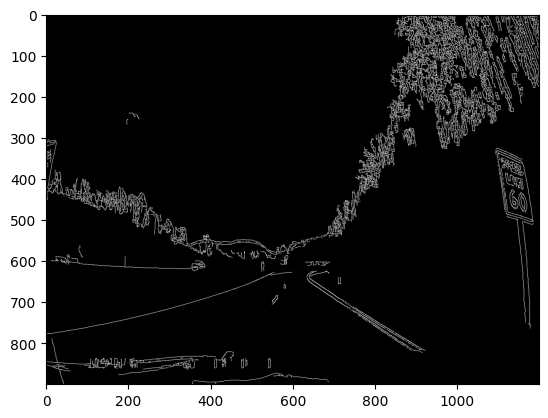

In [174]:
# Edge detection

image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

image_blur = cv2.blur(image, (5, 9))
image_edge = cv2.Canny(image_blur, 20, 100)

image_edge_rgb = cv2.cvtColor(image_edge, cv2.COLOR_GRAY2RGB)

plt.imshow(image_edge_rgb)

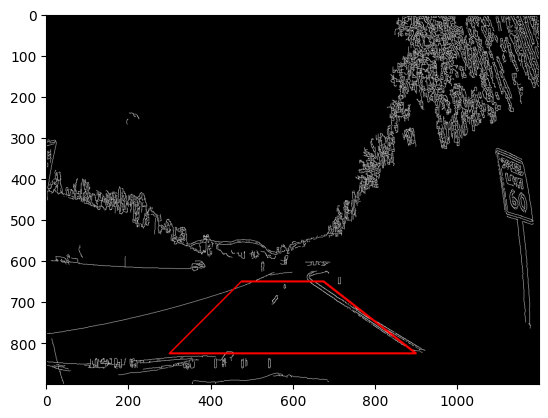

In [175]:
# Warp parameters

shape = image.shape[::-1][1:]

offset = 300 # crop inwards?

upper_bound = 650
lower_bound = 825

roi_points = np.float32([
    (475, upper_bound), # Top-left corner
    (300, lower_bound), # Bottom-left corner
    (900, lower_bound), # Bottom-right corner
    (675, upper_bound) # Top-right corner
])

image_points = np.float32([
    [offset, 0],
    [offset, shape[1]],
    [shape[0]-offset, shape[1]],
    [shape[0]-offset, 0]
])

warp_parameter_display = image_edge_rgb.copy()
poly = cv2.polylines(warp_parameter_display, np.int32([roi_points]), True, (255,0,0), 3)
plt.imshow(warp_parameter_display)

In [176]:
# Warp and unwarp matrix calculation

warp_matrix = cv2.getPerspectiveTransform(roi_points, image_points)
unwarp_matrix = cv2.getPerspectiveTransform(image_points, roi_points)

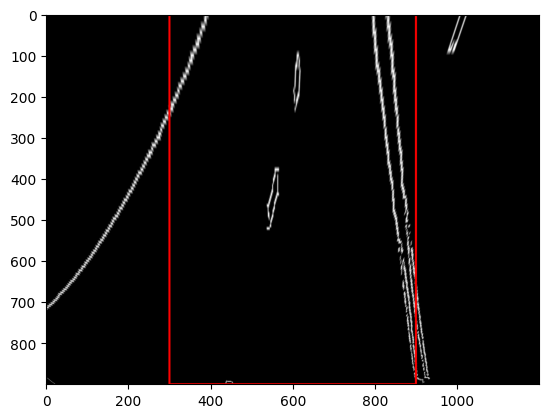

In [177]:
# Warp image
image_warp = cv2.warpPerspective(image_edge_rgb, warp_matrix, shape, flags=cv2.INTER_LINEAR)
binary_warped = cv2.cvtColor(image_warp, cv2.COLOR_RGB2GRAY)

image_warp_display = image_warp.copy()
poly = cv2.polylines(image_warp_display, np.int32([image_points]), True, (255,0,0), 3)
plt.imshow(image_warp_display)

In [178]:
# sliding box parameters
N_WINDOWS = 32
MARGIN = 100
RECENTER_MINPIX = 50

In [179]:
def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = int(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.copy()
    # Set height of windows
    window_height = int(binary_warped.shape[0]/n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

def get_lane_indices_from_prev_window(binary_warped_img, left_fit, right_fit, margin):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

Text(0.5, 1.0, 'Histogram of Lane line Pixels')

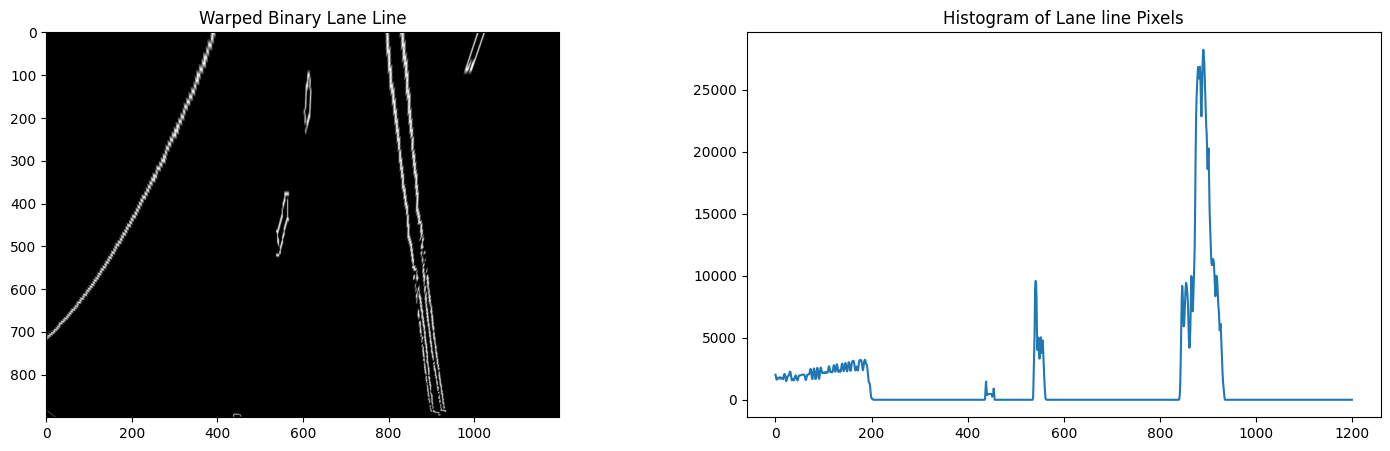

In [180]:
# Calculate histogram of lane line pixels
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

# Draw figure for warped binary and histogram
f, axarr = plt.subplots(1, 2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].plot(histogram)
axarr[0].set_title("Warped Binary Lane Line")
axarr[1].set_title("Histogram of Lane line Pixels")

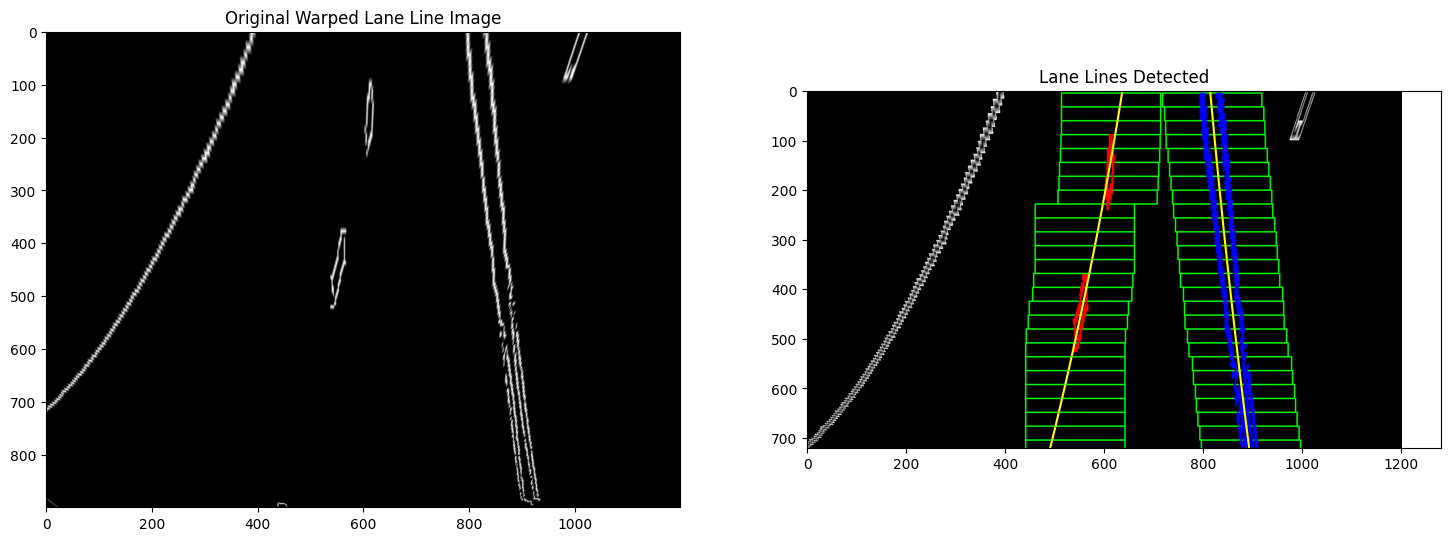

In [181]:
# Slide boxes
leftx_base, rightx_base = histo_peak(histogram)
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
    binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, image_warp.shape[0]-1, image_warp.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Draw figures of line lanes detected
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 10)
axarr[0].imshow(image_warp)
axarr[1].imshow(out_img)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Original Warped Lane Line Image")
axarr[1].set_title("Lane Lines Detected");
plt.xlim(0, 1280)
plt.ylim(720, 0);

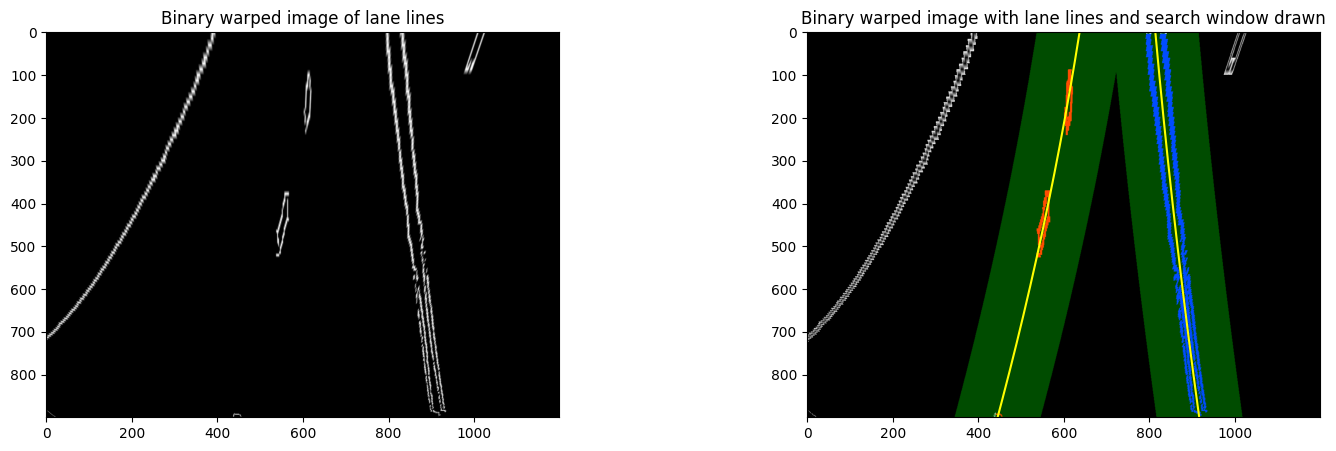

In [182]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN,
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN,
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the figure
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window drawn");

In [183]:
def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx[:len(ploty)], ploty]))])
    #pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

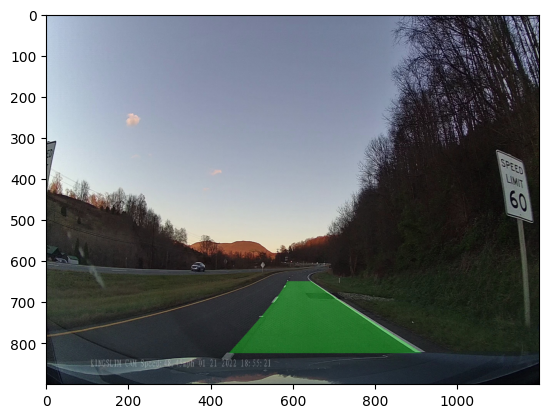

In [184]:
lane_line_area_display = image.copy()
result = project_lane_line(lane_line_area_display, binary_warped, ploty, left_fitx, right_fitx, unwarp_matrix)

plt.imshow(result)